In [1]:
# 가로로 넓게 쓰기
from IPython.core.display import display, HTML  
display(HTML(""))

print("Setup Complete")

Setup Complete


In [18]:
import time 
import datetime as dt
from datetime import datetime

import pandas as pd
import numpy as np
import os

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [19]:
from sklearn import model_selection

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error, r2_score, confusion_matrix, precision_score, recall_score, f1_score, auc, roc_curve, precision_recall_curve

from sklearn import tree
from sklearn import ensemble

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import lightgbm as lgb

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

from catboost import CatBoostClassifier

In [4]:
path = "/home/kym/ML/input/kamp/대회 과제"
os.chdir(path)

df = pd.read_csv('melting_tank.csv', encoding='cp949')
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK


In [5]:
df['MELT_TEMP'] = (df['MELT_TEMP'] / 10) # 용해온도, 교반속도 데이터는 소수점 1 자리 생략 
df['MOTORSPEED'] = (df['MOTORSPEED'] / 10)

result_mapping = {
    "OK": 1,
    "NG": 0
}

df.loc[:, "TAG"] = df.TAG.map(result_mapping)

In [6]:
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,48.9,11.6,631,3.19,1
1,2020-03-04 0:00,1,43.3,7.8,609,3.19,1
2,2020-03-04 0:00,2,46.4,15.4,608,3.19,1
3,2020-03-04 0:00,3,37.9,21.2,606,3.19,1
4,2020-03-04 0:00,4,79.8,173.6,604,3.21,1


In [7]:
df['STD_DT'] = df['STD_DT'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d %H:%M', errors='coerce'))
df.set_index('STD_DT', inplace=True)

In [8]:
df.head(1)

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT,,,,,,
2020-03-04,0,48.9,11.6,631,3.19,1


In [9]:
df.describe()

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
count,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000
mean,417599.500000,50.920062,45.978287,582.962125,3.194853,0.787994
std,241101.616752,12.827752,63.943641,1217.604433,0.011822,0.408729
min,0.000000,30.800000,0.000000,0.000000,3.170000,0.000000
25%,208799.750000,43.000000,11.900000,186.000000,3.190000,1.000000
50%,417599.500000,46.900000,16.800000,383.000000,3.190000,1.000000
75%,626399.250000,50.200000,21.800000,583.000000,3.200000,1.000000
max,835199.000000,83.200000,180.400000,55252.000000,3.230000,1.000000


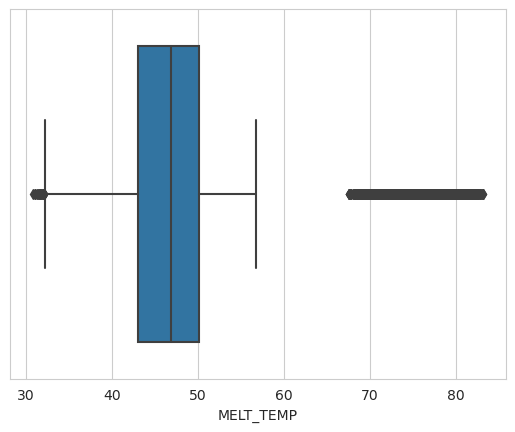

In [10]:
# 온도는 이상치 수준으로 보긴 어려움. 그대로 모두 사용 
sns.boxplot(x='MELT_TEMP', orient = "v", data=df)
plt.show()

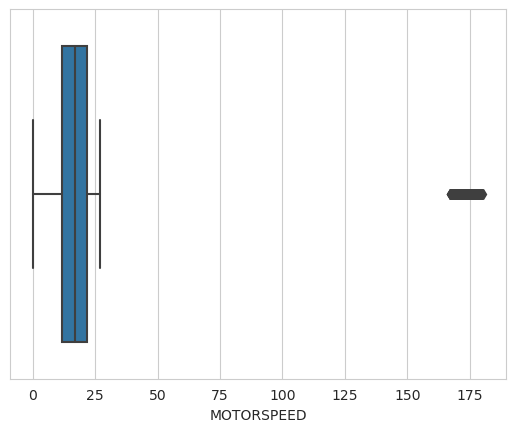

In [11]:
# 모터 스피드도 이상치로 보기 어려움. 
sns.boxplot(x='MOTORSPEED', orient = "v", data=df)
plt.show()

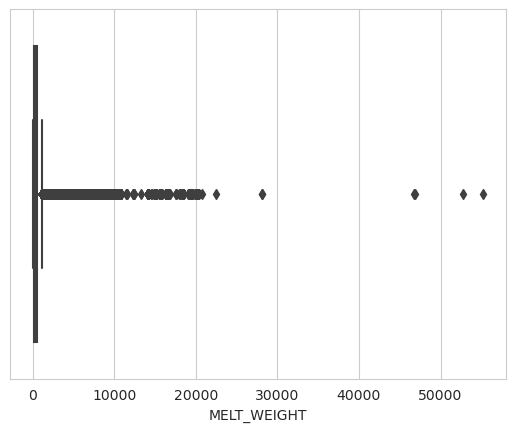

In [12]:
# 중량의 경우 너무 과한 값은 삭제 
sns.boxplot(x='MELT_WEIGHT', orient = "v", data=df)
plt.show()

In [13]:
df.head(1)

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT,,,,,,
2020-03-04,0,48.9,11.6,631,3.19,1


In [14]:
# 직접 관측 어려운 feature 는 제외 
df.drop(['INSP'], axis=1, inplace=True)

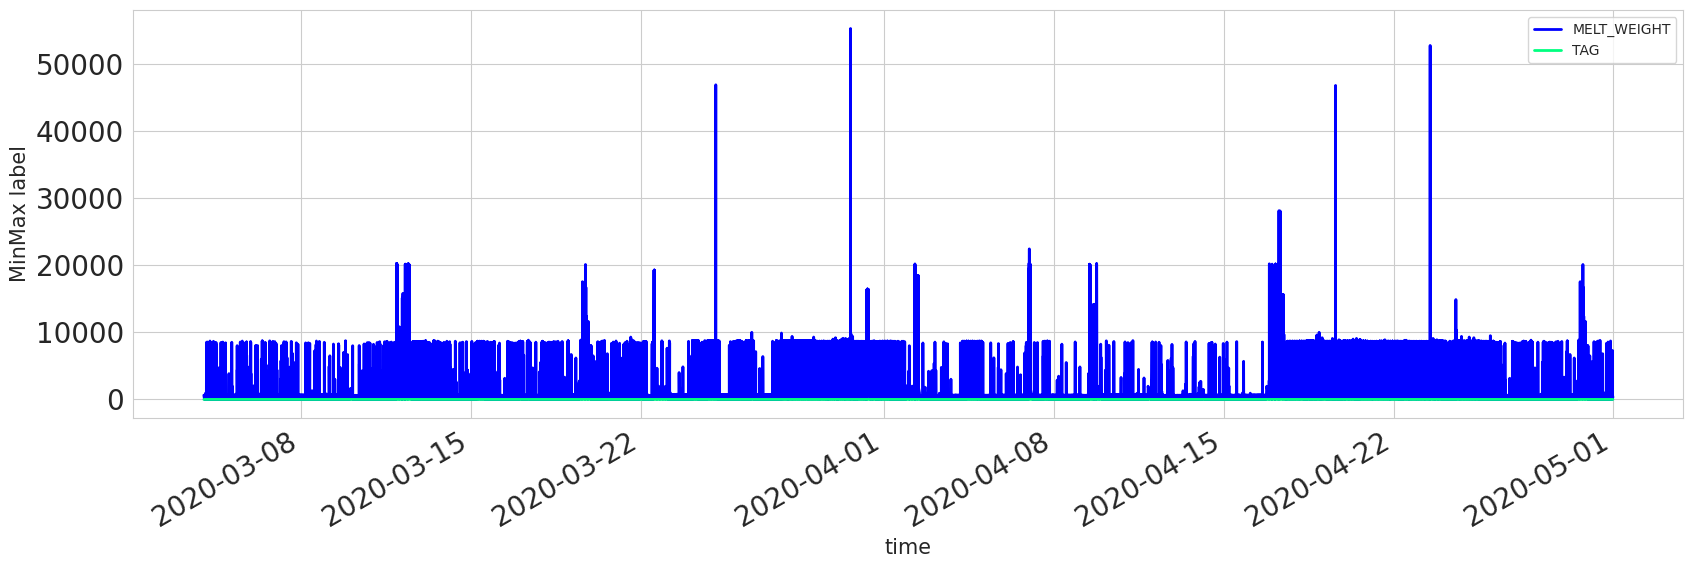

In [15]:
df[['MELT_WEIGHT', 'TAG']].plot(kind='line', figsize=(20,6), linewidth=2, fontsize=20, colormap='winter')
plt.xlabel('time', fontsize=15)
plt.ylabel('MinMax label', fontsize=15)
plt.show()

In [16]:
# 질량 전 처리 : 조건은 직전 값과 100이상 차이 나는 경우 시계열상 다다음 스텝(30스텝까지)의 무게와 비교해서 증감 비율 맞춰서 보정하는 형태
Dlength = df.shape[0]
s_step = 30

for k in df.NUM:
    if k >= 1:
        if abs(df.MELT_WEIGHT[k] - df.MELT_WEIGHT[k-1]) > 100:
            
            for s in range(s_step):
                if abs(df.MELT_WEIGHT[k-1] - df.MELT_WEIGHT[k+s]) < 500: 
                    step = round(abs(df.MELT_WEIGHT[k-1] - df.MELT_WEIGHT[k+s]) / (s+1))
                    
                    if df.MELT_WEIGHT[k-1] > df.MELT_WEIGHT[k+s]:
                        df.MELT_WEIGHT[k] = df.MELT_WEIGHT[k-1] - step
                    
                    else:
                        df.MELT_WEIGHT[k] = df.MELT_WEIGHT[k-1] + step
                    break

df.to_csv('/home/kym/ML/input/kamp/대회 과제/melting_tank_mod.csv')

In [140]:
path = "/home/kym/ML/input/kamp/대회 과제"
os.chdir(path)

df = pd.read_csv('melting_tank_mod.csv', encoding='cp949')
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
0,2020-03-04 00:00:00,0,48.9,11.6,631,1
1,2020-03-04 00:00:00,1,43.3,7.8,609,1
2,2020-03-04 00:00:00,2,46.4,15.4,608,1
3,2020-03-04 00:00:00,3,37.9,21.2,606,1
4,2020-03-04 00:00:00,4,79.8,173.6,604,1


In [141]:
df['STD_DT'] = df['STD_DT'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [142]:
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
0,2020-03-04,0,48.9,11.6,631,1
1,2020-03-04,1,43.3,7.8,609,1
2,2020-03-04,2,46.4,15.4,608,1
3,2020-03-04,3,37.9,21.2,606,1
4,2020-03-04,4,79.8,173.6,604,1


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835200 entries, 0 to 835199
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   STD_DT       835200 non-null  datetime64[ns]
 1   NUM          835200 non-null  int64         
 2   MELT_TEMP    835200 non-null  float64       
 3   MOTORSPEED   835200 non-null  float64       
 4   MELT_WEIGHT  835200 non-null  int64         
 5   TAG          835200 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 38.2 MB


In [144]:
def generate_features(df):
    df.loc[:,  'year'] = df['STD_DT'].dt.year
    df.loc[:, 'weekofyear'] = df['STD_DT'].dt.weekofyear
    df.loc[:, 'month'] = df['STD_DT'].dt.month
    df.loc[:, 'dayofweek'] = df['STD_DT'].dt.dayofweek
    df.loc[:, 'weekend'] = (df['STD_DT'].dt.weekday >=5).astype(int)
#     df.loc[:, 'hour'] = df['STD_DT'].dt.hour
#     df.loc[:, 'min'] = df['STD_DT'].dt.mimute
    
    aggs = {}
#     aggs['month'] = ['nunique', 'mean']
#     aggs['weekofyear'] = ['mean']
    aggs['MELT_TEMP'] = ['max', 'min', 'mean']
    aggs['MOTORSPEED'] = ['max', 'min', 'mean']
    aggs['MELT_WEIGHT'] = ['max', 'min', 'mean']
#     aggs['NUM'] = ['size']
#     aggs['NUM'] = ['nunique']
    
    agg_df = df.groupby('NUM').agg(aggs)
    agg_df = agg_df.reset_index()
    
    return agg_df

In [145]:
df1 = generate_features(df)
df1.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG,year,weekofyear,month,dayofweek,weekend
0,2020-03-04,0,48.9,11.6,631,1,2020,10,3,2,0
1,2020-03-04,1,43.3,7.8,609,1,2020,10,3,2,0
2,2020-03-04,2,46.4,15.4,608,1,2020,10,3,2,0
3,2020-03-04,3,37.9,21.2,606,1,2020,10,3,2,0
4,2020-03-04,4,79.8,173.6,604,1,2020,10,3,2,0


In [146]:
df = pd.concat([df, df1], axis=1)
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG,year,weekofyear,month,dayofweek,...,"(NUM, )","(MELT_TEMP, max)","(MELT_TEMP, min)","(MELT_TEMP, mean)","(MOTORSPEED, max)","(MOTORSPEED, min)","(MOTORSPEED, mean)","(MELT_WEIGHT, max)","(MELT_WEIGHT, min)","(MELT_WEIGHT, mean)"
0,2020-03-04,0,48.9,11.6,631,1,2020,10,3,2,...,0,48.9,48.9,48.9,11.6,11.6,11.6,631,631,631.0
1,2020-03-04,1,43.3,7.8,609,1,2020,10,3,2,...,1,43.3,43.3,43.3,7.8,7.8,7.8,609,609,609.0
2,2020-03-04,2,46.4,15.4,608,1,2020,10,3,2,...,2,46.4,46.4,46.4,15.4,15.4,15.4,608,608,608.0
3,2020-03-04,3,37.9,21.2,606,1,2020,10,3,2,...,3,37.9,37.9,37.9,21.2,21.2,21.2,606,606,606.0
4,2020-03-04,4,79.8,173.6,604,1,2020,10,3,2,...,4,79.8,79.8,79.8,173.6,173.6,173.6,604,604,604.0


In [150]:
from sklearn.feature_selection import VarianceThreshold

In [153]:
np.var(df)

NUM                    5.812992e+10
MELT_TEMP              1.645510e+02
MOTORSPEED             4.088784e+03
MELT_WEIGHT            1.006373e+05
TAG                    1.670592e-01
year                   0.000000e+00
weekofyear             5.857313e+00
month                  2.497027e-01
dayofweek              3.879013e+00
weekend                1.997622e-01
(NUM, )                5.812992e+10
(MELT_TEMP, max)       1.645510e+02
(MELT_TEMP, min)       1.645510e+02
(MELT_TEMP, mean)      1.645510e+02
(MOTORSPEED, max)      4.088784e+03
(MOTORSPEED, min)      4.088784e+03
(MOTORSPEED, mean)     4.088784e+03
(MELT_WEIGHT, max)     1.006373e+05
(MELT_WEIGHT, min)     1.006373e+05
(MELT_WEIGHT, mean)    1.006373e+05
dtype: float64

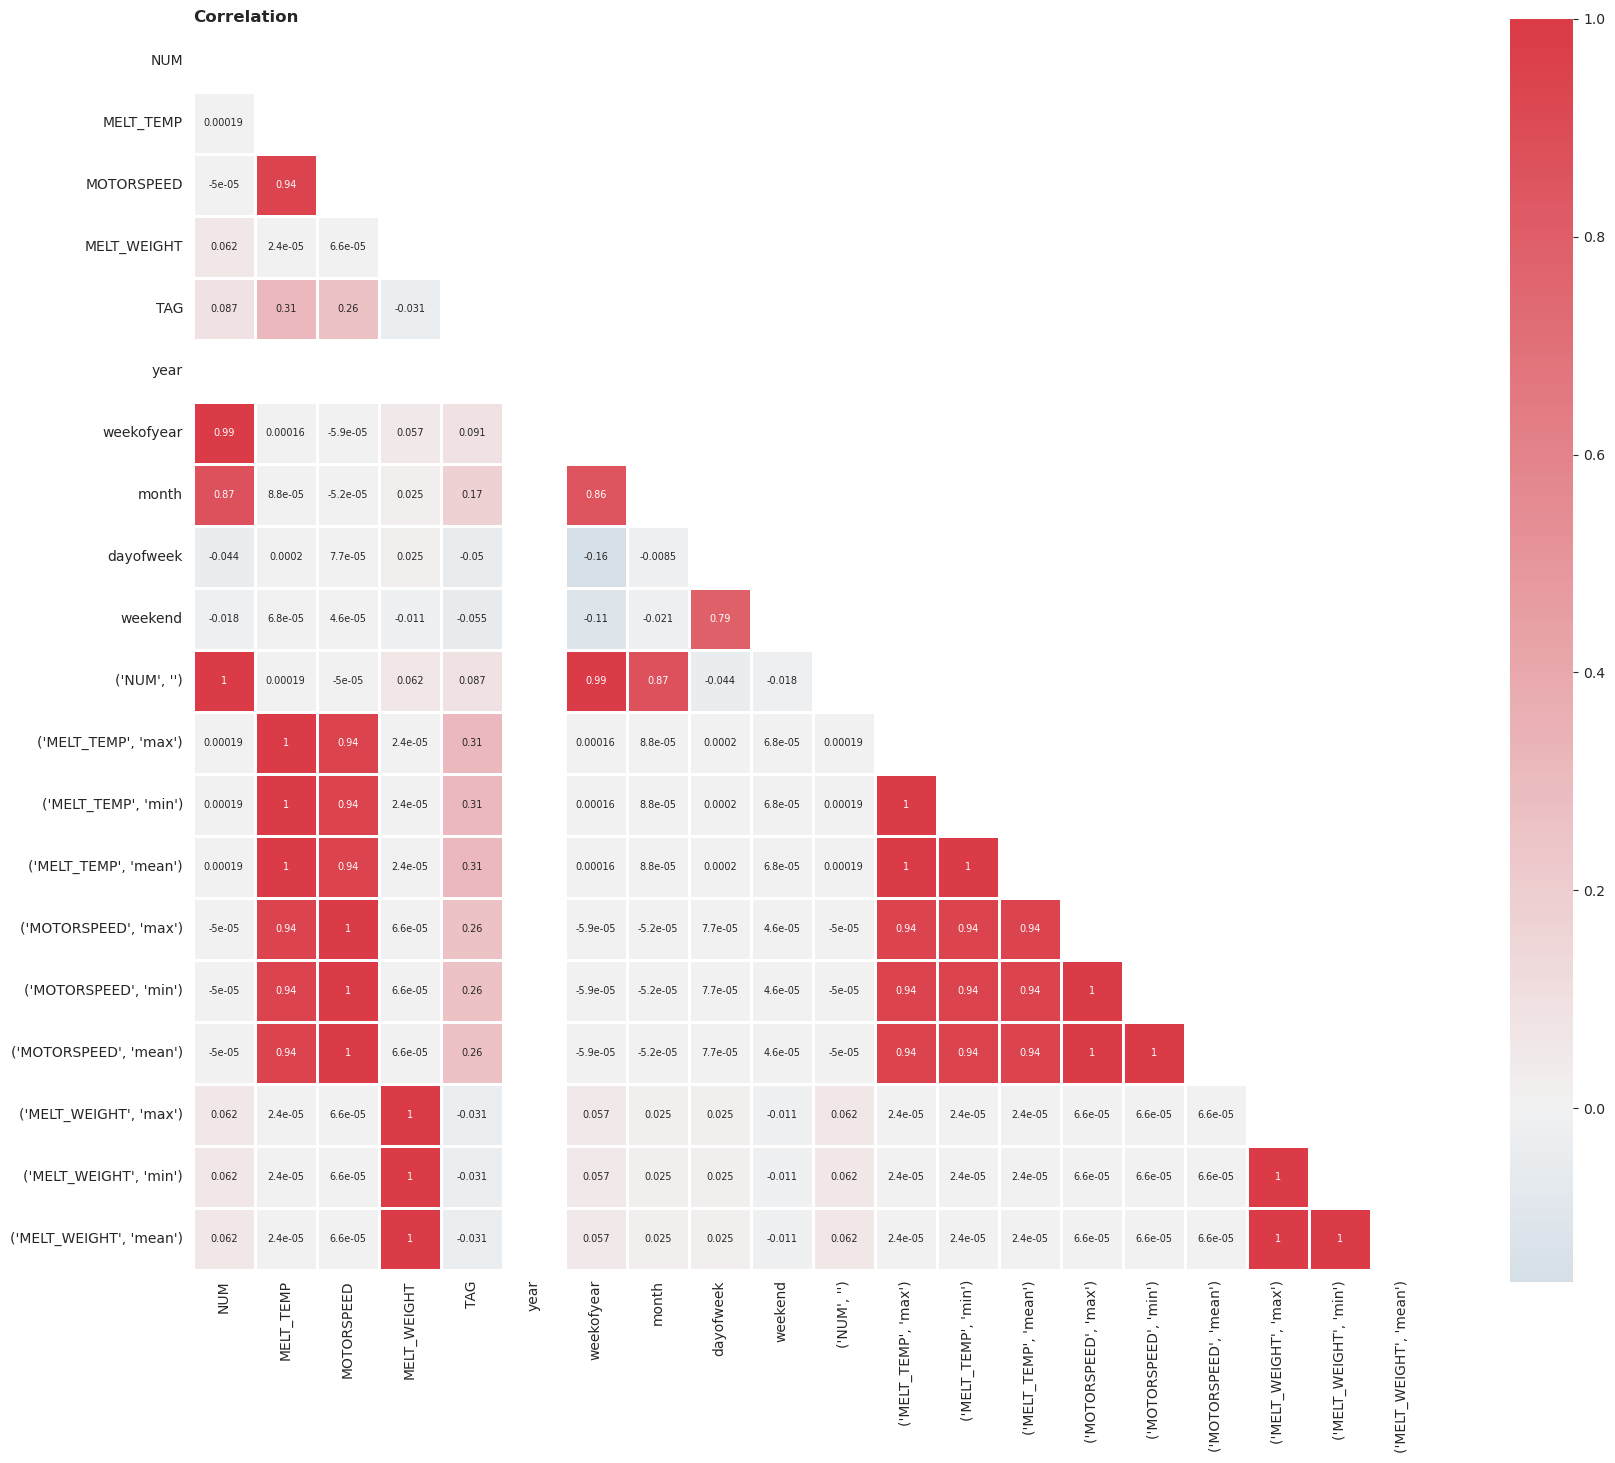

In [152]:
# Heatmap

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
df_corr = df.corr()

mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr, ax=ax,
           square=True, center=0, linewidth=1,
           cmap=sns.diverging_palette(240, 10, as_cmap=True),
           cbar_kws={'shrink': .82},
           mask=mask,
           annot=True,
           annot_kws={'size':7}
           )
ax.set_title(f'Correlation', loc='left', fontweight='bold')
plt.show()

In [154]:
df.describe()

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG,year,weekofyear,month,dayofweek,weekend,"(NUM, )","(MELT_TEMP, max)","(MELT_TEMP, min)","(MELT_TEMP, mean)","(MOTORSPEED, max)","(MOTORSPEED, min)","(MOTORSPEED, mean)","(MELT_WEIGHT, max)","(MELT_WEIGHT, min)","(MELT_WEIGHT, mean)"
count,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000,835200.0,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000
mean,417599.500000,50.920062,45.978287,414.582481,0.787994,2020.0,13.931034,3.517241,2.982759,0.275862,417599.500000,50.920062,50.920062,50.920062,45.978287,45.978287,45.978287,414.582481,414.582481,414.582481
std,241101.616752,12.827752,63.943641,317.234065,0.408729,0.0,2.420190,0.499703,1.969522,0.446948,241101.616752,12.827752,12.827752,12.827752,63.943641,63.943641,63.943641,317.234065,317.234065,317.234065
min,0.000000,30.800000,0.000000,0.000000,0.000000,2020.0,10.000000,3.000000,0.000000,0.000000,0.000000,30.800000,30.800000,30.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,208799.750000,43.000000,11.900000,186.000000,1.000000,2020.0,12.000000,3.000000,1.000000,0.000000,208799.750000,43.000000,43.000000,43.000000,11.900000,11.900000,11.900000,186.000000,186.000000,186.000000
50%,417599.500000,46.900000,16.800000,382.000000,1.000000,2020.0,14.000000,4.000000,3.000000,0.000000,417599.500000,46.900000,46.900000,46.900000,16.800000,16.800000,16.800000,382.000000,382.000000,382.000000
75%,626399.250000,50.200000,21.800000,579.000000,1.000000,2020.0,16.000000,4.000000,5.000000,1.000000,626399.250000,50.200000,50.200000,50.200000,21.800000,21.800000,21.800000,579.000000,579.000000,579.000000
max,835199.000000,83.200000,180.400000,2820.000000,1.000000,2020.0,18.000000,4.000000,6.000000,1.000000,835199.000000,83.200000,83.200000,83.200000,180.400000,180.400000,180.400000,2820.000000,2820.000000,2820.000000


In [ ]:
class GreedyFeatureSelection:
    def evaluate_score(self, X, y):
        model = xgb.XGBClassifier(random_state=42,
                                  booster='gbtree',
                                  n_jobs=-1,
                                  eval_metric='error',
                                  learning_rate=0.1,
                                  n_estimators=200,
                                  max_depth=5,
                                  reg_lambda=2
                                 )
        model.fit(X, y)
        pred = model.predict_proba(X)[:, 1]
        auc = metrics.roc_auc_score(y, predictions)
        
        return auc
    
    def _feature_selection(self, X, y):
        good_features = []
        best_scores = []
        num_features = X.shape[1]
        
        while True:
            this_feature = None
            best_score = 0
            
            for feature in range(num_features):
                if feature in good_features:
                    continue
                    
                selected_features = good_features + [feature]
                xtrain = X[:, selected_features]
                score = self.evaluate_score(xtrain, y)
                
                if score > best_score:
                    this_feature = feature
                    best_score = score
                    
            if this_feature != None:
                good_features.append(this_feature)
                best_scores.append(best_score)
                
            

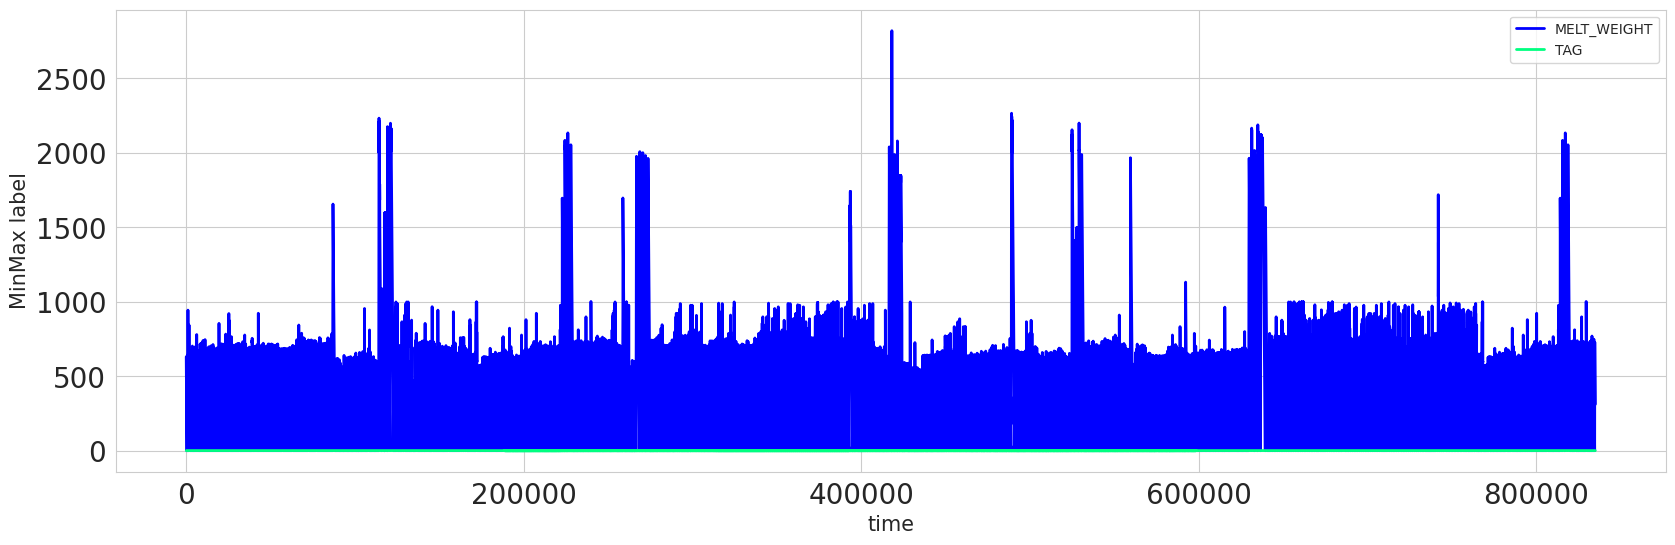

In [17]:
# 데이터 수정 이 후 
df[['MELT_WEIGHT', 'TAG']].plot(kind='line', figsize=(20,6), linewidth=2, fontsize=20, colormap='winter')
plt.xlabel('time', fontsize=15)
plt.ylabel('MinMax label', fontsize=15)
plt.show()

In [18]:
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
0,2020-03-04 00:00:00,0,48.9,11.6,631,1
1,2020-03-04 00:00:00,1,43.3,7.8,609,1
2,2020-03-04 00:00:00,2,46.4,15.4,608,1
3,2020-03-04 00:00:00,3,37.9,21.2,606,1
4,2020-03-04 00:00:00,4,79.8,173.6,604,1


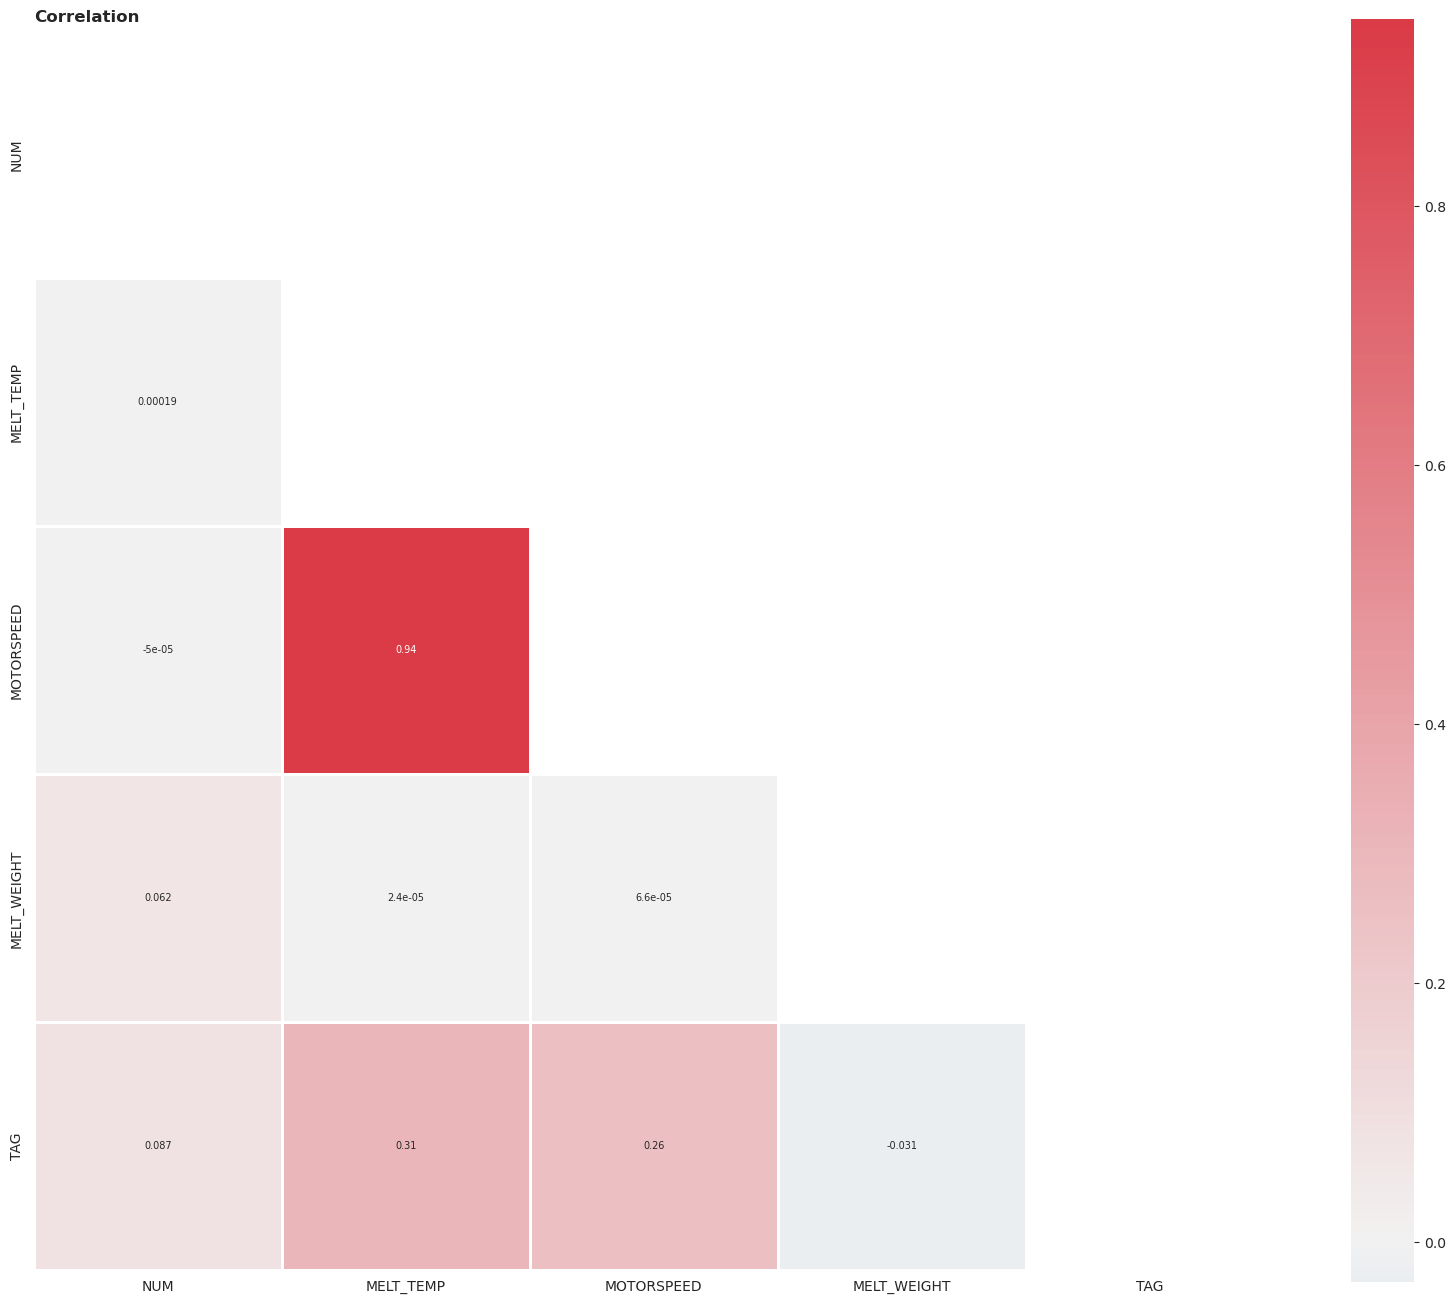

### 온도와 모터 스피드 간 높은 상관성 

In [20]:
# 피처별 점수
from functools import partial
from scipy import optimize

class OptimizeAUC:
    def __init__(self):
        self.coef_ = 0
        
    def _auc(self, coef, X, y):
        '''
        :params coef : weight list
        '''
        x_coef = X * coef
        predictions = np.sum(x_coef, axis=1)
        auc_score = metrics.roc_auc_score(y, predictions)
        
        return -1.0 * auc_score
    
    def fit(self, X, y):
        loss_partial = partial(self._auc, X=X, y=y)
        initial_coef = np.random.dirichlet(np.ones(X.shape[1]), size=1)
        self.coef_ = optimize.fmin(loss_partial, initial_coef, disp=True)
        
    def predict(self, X):
        x_coef = X * self.coef_
        predictions = np.sum(x_coef, axis=1)
        
        return predictions

In [21]:
df.head(1)

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
0,2020-03-04 00:00:00,0,48.9,11.6,631,1


In [22]:
X = df.drop(['STD_DT', 'NUM', 'TAG'], axis=1)
y = df['TAG']
X.head()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT
0,48.9,11.6,631
1,43.3,7.8,609
2,46.4,15.4,608
3,37.9,21.2,606
4,79.8,173.6,604


In [23]:
# 랜덤 포레스트, light GBM, XGBoost, DL, KNN => ENSEMBLE

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    X,
    y,
    test_size=0.5,
    stratify=y,
    shuffle=True,
    random_state=42
)

scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

lgb = lgb.LGBMClassifier(num_leaves=31, 
                         objective='binary',
                         num_iterations=200,
                         max_depth=5
                        )
rf = ensemble.RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier(n_jobs=-1)
xgb = xgb.XGBClassifier(random_state=42,
                       booster='gbtree',
                       n_jobs=-1,
                       eval_metric='error',
                       learning_rate=0.1,
                       n_estimators=200,
                       max_depth=5,
                       reg_lambda=2
                       )

lgb.fit(x_train_scaled, y_train)
rf.fit(x_train_scaled, y_train)
knn.fit(x_train_scaled, y_train)
xgb.fit(x_train_scaled, y_train)

pred_lgb = lgb.predict_proba(x_test_scaled)[:, 1]
pred_rf = rf.predict_proba(x_test_scaled)[:, 1]
pred_knn = knn.predict_proba(x_test_scaled)[:, 1]
pred_xgb = xgb.predict_proba(x_test_scaled)[:, 1]
avg_pred = (pred_xgb + pred_rf + pred_knn + pred_xgb) / 4

test_preds = np.column_stack((
            pred_lgb,
            pred_rf,
            pred_knn,
            pred_xgb,
            avg_pred
))

aucs_test = []

for i in range(test_preds.shape[1]):
    auc = metrics.roc_auc_score(y_test, test_preds[:, i])
    aucs_test.append(auc)
    
print(f"테스트 셋: LightGBM AUC = {aucs_test[0]}")
print(f"테스트 셋: RandomForest AUC = {aucs_test[1]}")
print(f"테스트 셋: KNN AUC = {aucs_test[2]}")
print(f"테스트 셋: XGBoost AUC = {aucs_test[3]}")
print(f"테스트 셋: Average Pred AUC = {aucs_test[4]}")

테스트 셋: LightGBM AUC = 0.8006075976464007
테스트 셋: RandomForest AUC = 0.7615250227560106
테스트 셋: KNN AUC = 0.7268879555456307
테스트 셋: XGBoost AUC = 0.8017942260569328
테스트 셋: Average Pred AUC = 0.7902928011113435


In [24]:
lgb.fit(x_test_scaled, y_test)
rf.fit(x_test_scaled, y_test)
knn.fit(x_test_scaled, y_test)
xgb.fit(x_test_scaled, y_test)

pred_lgb = lgb.predict_proba(x_train_scaled)[:, 1]
pred_rf = rf.predict_proba(x_train_scaled)[:, 1]
pred_knn = knn.predict_proba(x_train_scaled)[:, 1]
pred_xgb = xgb.predict_proba(x_train_scaled)[:, 1]
avg_pred = (pred_xgb + pred_rf + pred_knn + pred_xgb) / 4

train_preds = np.column_stack((
            pred_lgb,
            pred_rf,
            pred_knn,
            pred_xgb,
            avg_pred
))

aucs_train = []

for i in range(train_preds.shape[1]):
    auc = metrics.roc_auc_score(y_train, train_preds[:, i])
    aucs_train.append(auc)
    
print(f"테스트 셋: LightGBM AUC = {aucs_train[0]}")
print(f"테스트 셋: RandomForest AUC = {aucs_train[1]}")
print(f"테스트 셋: KNN AUC = {aucs_train[2]}")
print(f"테스트 셋: XGBoost AUC = {aucs_train[3]}")
print(f"테스트 셋: Average Pred AUC = {aucs_train[4]}")

테스트 셋: LightGBM AUC = 0.8028372419097605
테스트 셋: RandomForest AUC = 0.7622521238261448
테스트 셋: KNN AUC = 0.7274948697775255
테스트 셋: XGBoost AUC = 0.8040028448163482
테스트 셋: Average Pred AUC = 0.7920125760566077


In [25]:
opt = OptimizeAUC()
opt.fit(train_preds[:, :-1], y_train)
opt_preds_test = opt.predict(test_preds[:, :-1])
auc = metrics.roc_auc_score(y_test, opt_preds_test)

print(f"Optimized AUC, Test set = {auc}")
print(f"Coefficients = {opt.coef_}")

opt = OptimizeAUC()
opt.fit(test_preds[:, :-1], y_test)
opt_preds_train = opt.predict(train_preds[:, :-1])
auc = metrics.roc_auc_score(y_train, opt_preds_train)

print(f"Optimized AUC, Train set = {auc}")
print(f"Coefficients = {opt.coef_}")  

Optimization terminated successfully.
         Current function value: -0.804072
         Iterations: 110
         Function evaluations: 201
Optimized AUC, Test set = 0.8018541412833162
Coefficients = [ 0.0523267   0.00499057 -0.01525448  0.7181469 ]
Optimization terminated successfully.
         Current function value: -0.801857
         Iterations: 193
         Function evaluations: 342
Optimized AUC, Train set = 0.8040687773315218
Coefficients = [ 0.05395096  0.00301728 -0.00955842  0.40213344]


* 피처 1 개 (온도) : 0.774 (optimized auc 0.78)  
* 피처 1 개 (모터 속도) : 0.73 (optimized auc 0.736)  
* 피처 2 개 (온도, 모터 속도) : 0.77 (optimized auc 0.78)  
* 피처 3 개 (온도, 모터 속도, 중량): 0.79 (optimized auc 0.80)  
* 피처 4 개 (온도, 모터 속도, 중량, insp) : 0.79 (optimized auc 0.80)  

### 온도, 모터 속도, 중량까지만 학습에 사용 : Metric 뿐만 아니라 데이터 수집 측면에서 INSP 는 불리하기 때문임.

In [26]:
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
0,2020-03-04 00:00:00,0,48.9,11.6,631,1
1,2020-03-04 00:00:00,1,43.3,7.8,609,1
2,2020-03-04 00:00:00,2,46.4,15.4,608,1
3,2020-03-04 00:00:00,3,37.9,21.2,606,1
4,2020-03-04 00:00:00,4,79.8,173.6,604,1


In [27]:
# # label check (extremely imbalanced label, real world)
# df['TAG'].plot(kind='pie', autopct='%0.1f%%')